<a href="https://colab.research.google.com/github/AlexeyTri/MLSeminars/blob/main/MLHSE/%D0%97%D0%B0%D0%BD%D1%8F%D1%82%D0%B8%D0%B5_13_RecSys.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [43]:
%pylab inline

import numpy as np
import pandas as pd
import math

from tqdm import tqdm_notebook

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.9/dist-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['svd']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [ ]:
!pip install --user kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
    print('User upload file "{name}" with lenght {lenght} bytes'.format(name=fn, lenght=len(uploaded[fn])))

!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User upload file "kaggle.json" with lenght 68 bytes


In [ ]:
! kaggle competitions list

ref                                                                                 deadline             category            reward  teamCount  userHasEntered  
----------------------------------------------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
https://www.kaggle.com/competitions/vesuvius-challenge-ink-detection                2023-06-14 23:59:00  Featured          $250,000          0           False  
https://www.kaggle.com/competitions/asl-signs                                       2023-05-01 23:59:00  Research          $100,000        519           False  
https://www.kaggle.com/competitions/tlvmc-parkinsons-freezing-gait-prediction       2023-06-08 23:59:00  Research          $100,000         88           False  
https://www.kaggle.com/competitions/amp-parkinsons-disease-progression-prediction   2023-05-18 23:59:00  Featured           $60,000        551           False  
https://www.kaggle.com/competition

In [ ]:
! kaggle datasets list -h

usage: kaggle datasets list
       [-h]
       [--sort-by SORT_BY]
       [--size SIZE]
       [--file-type FILE_TYPE]
       [--license LICENSE_NAME]
       [--tags TAG_IDS]
       [-s SEARCH]
       [-m]
       [--user USER]
       [-p PAGE]
       [-v]
       [--max-size MAX_SIZE]
       [--min-size MIN_SIZE]

optional arguments:
  -h, --help
    show this help message and exit
  --sort-by SORT_BY
    Sort list results. Default is 'hottest'. Valid options are 'hottest', 'votes', 'updated', and 'active'
  --size SIZE
    DEPRECATED. Please use --max-size and --min-size to filter dataset sizes.
  --file-type FILE_TYPE
    Search for datasets with a specific file type. Default is 'all'. Valid options are 'all', 'csv', 'sqlite', 'json', and 'bigQuery'. Please note that bigQuery datasets cannot be downloaded
  --license LICENSE_NAME
    Search for datasets with a specific license. Default is 'all'. Valid options are 'all', 'cc', 'gpl', 'odb', and 'other'
  --tags TAG_IDS
    Search for d

In [ ]:
! kaggle datasets download -d gspmoreira/articles-sharing-reading-from-cit-deskdrop

 85% 7.00M/8.20M [00:00<00:00, 13.3MB/s]
100% 8.20M/8.20M [00:00<00:00, 10.6MB/s]


In [ ]:
! unzip articles-sharing-reading-from-cit-deskdrop.zip

Archive:  articles-sharing-reading-from-cit-deskdrop.zip
  inflating: shared_articles.csv     
  inflating: users_interactions.csv  


In [ ]:
articls_df = pd.read_csv('shared_articles.csv')

In [ ]:
articls_df = articls_df[articls_df['eventType'] == 'CONTENT SHARED']


In [ ]:
interactions_df = pd.read_csv('/content/users_interactions.csv')

In [ ]:
interactions_df.personId = interactions_df.personId.astype(str)
interactions_df.contentId = interactions_df.contentId.astype(str)
articls_df.contentId = articls_df.contentId.astype(str)

In [ ]:
event_type_strenght = {
    'VIEW': 1.0,
    'LIKE': 2.0,
    'BOOKMARK': 2.5,
    'FOLLOW': 3.0,
    'COMMENT CREATED': 4.0
}

In [ ]:
interactions_df['eventStrength'] = interactions_df.eventType.apply(lambda x: event_type_strenght[x])

In [ ]:
users_interactions_count_df = (
    interactions_df.groupby(['personId', 'contentId'])
    .first()
    .reset_index()
    .groupby(['personId']).size()
)

In [ ]:
users_with_enough_df = users_interactions_count_df[users_interactions_count_df >=5].reset_index()[['personId']]

<AxesSubplot:>

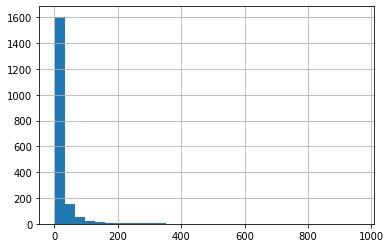

In [ ]:
users_interactions_count_df.hist(bins=30)

In [ ]:
interactions_from_selected_users_df = interactions_df.loc[np.in1d(interactions_df.personId, users_with_enough_df)]

In [ ]:
def smooth_user_preference(x):
    return np.log2(1+x)
    # return math.log(1+x, 2)

In [ ]:
interactions_full_df = (
    interactions_from_selected_users_df.groupby(['personId', 'contentId']).eventStrength.sum()
    .apply(smooth_user_preference).reset_index().set_index(['personId', 'contentId'])
)

In [ ]:
interactions_full_df['last_timestamp'] = (
    interactions_from_selected_users_df.groupby(['personId', 'contentId'])['timestamp'].last()
)

In [ ]:
interactions_full_df = interactions_full_df.reset_index()

In [ ]:
interactions_full_df

,personId,contentId,eventStrength,last_timestamp
0,-1007001694607905623,-5065077552540450930,1.000000,1470395911
1,-1007001694607905623,-6623581327558800021,1.000000,1487240080
2,-1007001694607905623,-793729620925729327,1.000000,1472834892
3,-1007001694607905623,1469580151036142903,1.000000,1487240062
4,-1007001694607905623,7270966256391553686,1.584963,1485994324
...,...,...,...,...
39101,998688566268269815,-401664538366009049,1.000000,1474567449
39102,998688566268269815,3456674717452933449,2.584963,1478802088
39103,998688566268269815,6881796783400625893,1.000000,1474567675
39104,998688566268269815,7174452660053929140,2.321928,1478812905


In [148]:
from sklearn.model_selection import train_test_split

split_ts = 1475519530
interactions_train_df = interactions_full_df.loc[interactions_full_df.last_timestamp < split_ts].copy()
interactions_test_df = interactions_full_df.loc[interactions_full_df.last_timestamp >= split_ts].copy()

print('# interactions on Train set: %d' % len(interactions_train_df))
print('# interactions on Test set: %d' % len(interactions_test_df))

interactions_train_df

# interactions on Train set: 29329
# interactions on Test set: 9777


,personId,contentId,eventStrength,last_timestamp
0,-1007001694607905623,-5065077552540450930,1.0,1470395911
2,-1007001694607905623,-793729620925729327,1.0,1472834892
6,-1032019229384696495,-1006791494035379303,1.0,1469129122
7,-1032019229384696495,-1039912738963181810,1.0,1459376415
8,-1032019229384696495,-1081723567492738167,2.0,1464054093
...,...,...,...,...
39099,997469202936578234,9112765177685685246,2.0,1472479493
39100,998688566268269815,-1255189867397298842,1.0,1474567164
39101,998688566268269815,-401664538366009049,1.0,1474567449
39103,998688566268269815,6881796783400625893,1.0,1474567675


In [149]:
interactions = (
    interactions_train_df
    .groupby('personId')['contentId'].agg(lambda x: list(x))
    .reset_index()
    .rename(columns={'contentId': 'true_train'})
    .set_index('personId')
)

interactions['true_test'] = (
    interactions_test_df
    .groupby('personId')['contentId'].agg(lambda x: list(x))
)

# заполнение пропусков пустыми списками
interactions.loc[pd.isnull(interactions.true_test), 'true_test'] = [
    [''] for x in range(len(interactions.loc[pd.isnull(interactions.true_test), 'true_test']))]

interactions.head(5)

,true_train,true_test
personId,,
-1007001694607905623,"[-5065077552540450930, -793729620925729327]","[-6623581327558800021, 1469580151036142903, 72..."
-1032019229384696495,"[-1006791494035379303, -1039912738963181810, -...","[-1415040208471067980, -2555801390963402198, -..."
-108842214936804958,"[-1196068832249300490, -133139342397538859, -1...","[-2780168264183400543, -3060116862184714437, -..."
-1130272294246983140,"[-1150591229250318592, -1196068832249300490, -...","[-1606980109000976010, -1663441888197894674, -..."
-1160159014793528221,"[-133139342397538859, -387651900461462767, 377...",[-3462051751080362224]


## 1 BASELINE - модель по популярности

In [67]:
popular_content = (
    interactions_train_df
    .groupby('contentId')
    .eventStrength.sum().reset_index()
    .sort_values('eventStrength', ascending=False)
    .contentId.values
)

In [68]:
articls_df.loc[articls_df.contentId == popular_content[1]]['title'].values

array(['Novo workaholic trabalha, pratica esportes e tem tempo para a família. Conheça'],
      dtype=object)

In [69]:
top_k = 10

interactions['prediction_popular'] = (
    interactions.true_train
    .apply(
        lambda x:
        popular_content[~np.in1d(popular_content, x)][:top_k]
    )
)

interactions['prediction_popular'][0]

array(['-6783772548752091658', '-133139342397538859',
       '-8208801367848627943', '8224860111193157980',
       '7507067965574797372', '-2358756719610361882',
       '-6843047699859121724', '-1297580205670251233',
       '8657408509986329668', '3367026768872537336'], dtype=object)

In [70]:
def calc_precision(column):
    return (
        interactions
        .apply(
            lambda row:
            len(set(row['true_test']).intersection(
                set(row[column]))) /
            min(len(row['true_test']) + 0.001, 10.0),
            axis=1)).mean()

In [71]:
calc_precision('prediction_popular')

0.006454207722621089

## 2 COLLABORATIVE FILTER

In [150]:
ratings = pd.pivot_table(
    interactions_train_df,
    values='eventStrength',
    index='personId',
    columns='contentId'
).fillna(0)

In [73]:
ratings

contentId,-1006791494035379303,-1021685224930603833,-1022885988494278200,-1024046541613287684,-1033806831489252007,-1038011342017850,-1039912738963181810,-1046621686880462790,-1051830303851697653,-1055630159212837930,...,9217155070834564627,921770761777842242,9220445660318725468,9222265156747237864,943818026930898372,957332268361319692,966067567430037498,972258375127367383,980458131533897249,98528655405030624
personId,,,,,,,,,,,,,,,,,,,,,
-1007001694607905623,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
-1032019229384696495,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,3.0,0.0,0.0,0.0,2.321928,0.0,0.0,0.0,0.0,0.0
-108842214936804958,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,2.0,0.0,0.0,0.0
-1130272294246983140,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.0
-1160159014793528221,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
953707509720613429,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
983095443598229476,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
989049974880576288,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


In [74]:
ratings_m = ratings.values

In [75]:
similarity_users = np.zeros((len(ratings_m), len(ratings_m)))

for i in tqdm_notebook(range(len(ratings_m)-1)):
    for j in range(i+1, len(ratings_m)):
        
        # nonzero elements of two users
        mask_uv = (ratings_m[i] != 0) & (ratings_m[j] != 0)
        
        # continue if no intersection
        if np.sum(mask_uv) == 0:
            continue
            
        # get nonzero elements
        ratings_v = ratings_m[i, mask_uv]
        ratings_u = ratings_m[j, mask_uv]
        
        # for nonzero std
        if len(np.unique(ratings_v)) < 2 or len(np.unique(ratings_u)) < 2:
            continue

        similarity_users[i,j] = np.corrcoef(ratings_v, ratings_u)[0, 1]
        similarity_users[j,i] = similarity_users[i,j]



<ipython-input-75-86175ec9a813>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(len(ratings_m)-1)):


  0%|          | 0/1111 [00:00<?, ?it/s]

In [76]:
prediction_user_based = []

for i in tqdm_notebook(range(len(similarity_users))):

    users_sim = similarity_users[i] > 0

    if len(users_sim) == 0:
        prediction_user_based.append([])
    else:
        tmp_recommend = np.argsort(ratings_m[users_sim].sum(axis=0))[::-1]
        tmp_recommend = ratings.columns[tmp_recommend]
        recommend = np.array(tmp_recommend)[~np.in1d(tmp_recommend, interactions.iloc[i])][:10]
        prediction_user_based.append(list(recommend))

interactions['prediction_user_based'] = prediction_user_based

<ipython-input-76-a0a2c85b3d06>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(len(similarity_users))):


  0%|          | 0/1112 [00:00<?, ?it/s]

In [77]:
calc_precision('prediction_user_based')

0.0033918377988156998

## SVD in ratings

In [78]:
from scipy.linalg import svd

In [79]:
U, sigma, V = svd(ratings)

print(ratings.shape, U.shape, sigma.shape, V.shape)

(1112, 2366) (1112, 1112) (1112,) (2366, 2366)


In [80]:
Sigma = np.zeros((1112, 2366))
Sigma[:1112, :1112] = np.diag(sigma)

new_ratings = U.dot(Sigma).dot(V)

print(sum(sum((new_ratings - ratings.values) ** 2)))

9.925722114202145e-25


In [81]:
K = 100

sigma[K:] = 0
Sigma = np.zeros((1112, 2366))
Sigma[:1112, :1112] = np.diag(sigma)

In [82]:
new_ratings = U.dot(Sigma).dot(V)

print(sum(sum((new_ratings - ratings.values) ** 2)))
print(sum(sum((ratings.values.mean() - ratings.values) ** 2)))

25843.424898912766
78622.13000466056


In [83]:
new_ratings = pd.DataFrame(new_ratings, index=ratings.index, columns=ratings.columns)

predictions = []

for personId in tqdm_notebook(interactions.index):
    prediction = (
        new_ratings
        .loc[personId]
        .sort_values(ascending=False)
        .index.values
    )
    
    predictions.append(
        list(prediction[~np.in1d(
            prediction,
            interactions.loc[personId, 'true_train'])])[:top_k])

interactions['prediction_svd'] = predictions

<ipython-input-83-28944ec765f3>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for personId in tqdm_notebook(interactions.index):


  0%|          | 0/1112 [00:00<?, ?it/s]

In [84]:
calc_precision('prediction_svd')

0.012212989310270756

## CONTENTS MODEL

In [151]:
test_personId = np.repeat(interactions.index, len(ratings.columns)) 
test_contentId = list(ratings.columns) * len(interactions)
test = pd.DataFrame(
    np.array([test_personId, test_contentId]).T,
    columns=['personId', 'contentId'])

interactions_train_df = pd.concat((
    interactions_train_df,
    test.loc[
        np.random.permutation(test.index)[
            :4*len(interactions_train_df)]]), ignore_index=True)
interactions_train_df.eventStrength.fillna(0, inplace=True)

In [153]:
interactions_train_df = interactions_train_df.merge(articls_df, how='left', on='contentId')
interactions_test_df = interactions_test_df.merge(articls_df, how='left', on='contentId')

In [154]:
# first feature index
features_start = len(interactions_train_df.columns)

In [155]:
test_personId = np.repeat(interactions.index, len(articls_df)) 
test_contentId = list(articls_df.contentId) * len(interactions)
test = pd.DataFrame(
    np.array([test_personId, test_contentId]).T,
    columns=['personId', 'contentId'])
test = test.merge(articls_df, how='left', on='contentId')

test.head()

,personId,contentId,timestamp,eventType,authorPersonId,authorSessionId,authorUserAgent,authorRegion,authorCountry,contentType,url,title,text,lang
0,-1007001694607905623,-4110354420726924665,1459193988,CONTENT SHARED,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
1,-1007001694607905623,-7292285110016212249,1459194146,CONTENT SHARED,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://cointelegraph.com/news/bitcoin-future-w...,Bitcoin Future: When GBPcoin of Branson Wins O...,The alarm clock wakes me at 8:00 with stream o...,en
2,-1007001694607905623,-6151852268067518688,1459194474,CONTENT SHARED,3891637997717104548,-1457532940883382585,NaN,NaN,NaN,HTML,https://cloudplatform.googleblog.com/2016/03/G...,Google Data Center 360° Tour,We're excited to share the Google Data Center ...,en
3,-1007001694607905623,2448026894306402386,1459194497,CONTENT SHARED,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,https://bitcoinmagazine.com/articles/ibm-wants...,"IBM Wants to ""Evolve the Internet"" With Blockc...",The Aite Group projects the blockchain market ...,en
4,-1007001694607905623,-2826566343807132236,1459194522,CONTENT SHARED,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.coindesk.com/ieee-blockchain-oxford...,IEEE to Talk Blockchain at Cloud Computing Oxf...,One of the largest and oldest organizations fo...,en


In [156]:
interactions_train_df['is_HTML'] = interactions_train_df.contentType == 'HTML'
interactions_train_df['is_RICH'] = interactions_train_df.contentType == 'RICH'
interactions_train_df['is_VIDEO'] = interactions_train_df.contentType == 'VIDEO'

test['is_HTML'] = test.contentType == 'HTML'
test['is_RICH'] = test.contentType == 'RICH'
test['is_VIDEO'] = test.contentType == 'VIDEO'

In [157]:
interactions_train_df['title_length'] = interactions_train_df.title.fillna('').apply(len)
interactions_train_df['text_length'] = interactions_train_df.text.fillna('').apply(len)

test['title_length'] = test.title.fillna('').apply(len)
test['text_length'] = test.text.fillna('').apply(len)

interactions_train_df['has_new'] = \
    interactions_train_df.title.fillna('').apply(lambda x: 'new' in x.lower())
interactions_train_df['has_why'] = \
    interactions_train_df.title.fillna('').apply(lambda x: 'why' in x.lower())
interactions_train_df['has_how'] = \
    interactions_train_df.title.fillna('').apply(lambda x: 'how' in x.lower())
interactions_train_df['has_ai'] = \
    interactions_train_df.title.fillna('').apply(lambda x: 'ai' in x.lower())

test['has_new'] = \
    test.title.fillna('').apply(lambda x: 'new' in x.lower())
test['has_why'] = \
    test.title.fillna('').apply(lambda x: 'why' in x.lower())
test['has_how'] = \
    test.title.fillna('').apply(lambda x: 'how' in x.lower())
test['has_ai'] = \
    test.title.fillna('').apply(lambda x: 'ai' in x.lower())

In [158]:
interactions_train_df['is_lang_en'] = interactions_train_df.lang == 'en'
interactions_train_df['is_lang_pt'] = interactions_train_df.lang == 'pt'

test['is_lang_en'] = test.lang == 'en'
test['is_lang_pt'] = test.lang == 'pt'

In [ ]:
!pip install catboost

In [ ]:
import catboost
model = catboost.CatBoostClassifier()
model.fit(interactions_train_df[interactions_train_df.columns[features_start:]],
          np.array(interactions_train_df.eventStrength > 0, dtype=int))

In [160]:
top_k = 10

predictions = model.predict_proba(test[interactions_train_df.columns[features_start:]])[:, 1]
test['predictions'] = predictions

In [161]:
test = test.sort_values('predictions', ascending=True)
predictions = test.groupby('personId')['contentId'].aggregate(list)
tmp_predictions = []

for personId in tqdm_notebook(interactions.index):
    prediction = np.array(predictions.loc[personId])

    tmp_predictions.append(
        list(prediction[~np.in1d(prediction, interactions.loc[personId, 'true_train'])])[:top_k]

    )

interactions['prediction_content'] = tmp_predictions

<ipython-input-161-9b41d8ce340f>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for personId in tqdm_notebook(interactions.index):


  0%|          | 0/1112 [00:00<?, ?it/s]

In [162]:
calc_precision('prediction_content')

0.0012588679431336915

## FACTORISATION MASHINE


In [163]:
!pip install pyfm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 634.6/634.6 KB 23.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyfm: filename=pyfm-0.2.4-py3-none-any.whl size=13230 sha256=3e1fe582c8a6c2e8921239444cb01ed61a005127d5d80207a005cb0d6f42cf15
  Stored in directory: /root/.cache/pip/wheels/c9/26/af/cf7ad3d9b212638cb3f378af52a3871edf9cd0941b88178f4e
  Created wheel for urwid: filename=urwid-2.1.2-cp39-cp39-linux_x86_64.whl size=259620 sha256=1c0067cdb21ff202a7b3c1f2f0ceb1ac8980dab26acfde726f61b8c69373c39c
  Stored in directory: /root/.cache/pip/wheels/44/ec/04/2c1080c3ee4e80e76d662ac35f0594a2a86f9df12095b05cb3
Successfully built pyfm urwid


In [165]:
!pip install git+https://github.com/coreylynch/pyFM

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/coreylynch/pyFM to /tmp/pip-req-build-mkz8kcex
  Running command git clone --filter=blob:none --quiet https://github.com/coreylynch/pyFM /tmp/pip-req-build-mkz8kcex
  Resolved https://github.com/coreylynch/pyFM to commit 0696c980993889a9429e4ab0b6c7dc8be6dac4de
  Preparing metadata (setup.py) ... done
  Created wheel for pyfm: filename=pyfm-0.0.0-cp39-cp39-linux_x86_64.whl size=320284 sha256=bc9665b3e91c54218e6dd66382a86d06c6378d03b2f7e0ff0f6c0e076adf8071
  Stored in directory: /tmp/pip-ephem-wheel-cache-ngt7iecb/wheels/20/32/78/864c9f42cd82e3ce9f5cf64e79abd2aa032791e44aa55ad3d3
Successfully built pyfm
  Attempting uninstall: pyfm
    Found existing installation: pyfm 0.2.4
    Uninstalling pyfm-0.2.4:
      Successfully uninstalled pyfm-0.2.4


In [166]:
from pyfm import pylibfm
from sklearn.feature_extraction import DictVectorizer

In [168]:
train_data = []

for i in tqdm_notebook(range(len(interactions_train_df))):
    features = {}
    features['personId'] = str(interactions_train_df.iloc[i].personId)
    features['contentId'] = str(interactions_train_df.iloc[i].contentId)

    try:
        article = articls_df.loc[features['contentId']]
        features['authorId'] = str(article.authorPersonId)
        features['authorCountry'] = str(article.authorCountry)
        features['lang'] = str(article.lang)
    except:
        features['authorId'] = 'unknown'
        features['authorCountry'] = 'unknown'
        features['lang'] = 'unknown'

    train_data.append(features)

<ipython-input-168-494e64d881c5>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(len(interactions_train_df))):


  0%|          | 0/146645 [00:00<?, ?it/s]

In [169]:
from copy import deepcopy

test_data = []

for i in tqdm_notebook(range(len(interactions))):
    features = {}
    features['personId'] = str(interactions.index[i])  
    for j in range(len(ratings.columns)):

        features['contentId'] = str(ratings.columns[j])
        
        try:
            article = articls_df.loc[features['contentId']]
            features['authorId'] = str(article.authorPersonId)
            features['authorCountry'] = str(article.authorCountry)
            features['lang'] = str(article.lang)
        except:
            features['authorId'] = 'unknown'
            features['authorCountry'] = 'unknown'
            features['lang'] = 'unknown'

        test_data.append(deepcopy(features))

<ipython-input-169-9b2305e8d534>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(len(interactions))):


  0%|          | 0/1112 [00:00<?, ?it/s]

In [170]:
dv = DictVectorizer()

train_features = dv.fit_transform(
    train_data + list(np.random.permutation(test_data)[:100000]))
test_features = dv.transform(test_data)

In [171]:
train_features

<246645x3481 sparse matrix of type '<class 'numpy.float64'>'
	with 1233225 stored elements in Compressed Sparse Row format>

In [172]:
y_train = list(interactions_train_df.eventStrength.values) + list(np.zeros(100000))

In [173]:
fm = pylibfm.FM(num_factors=10, num_iter=30, task='regression')

fm.fit(train_features, y_train)

Creating validation dataset of 0.01 of training for adaptive regularization
-- Epoch 1
Training MSE: 0.11769
-- Epoch 2
Training MSE: 0.11195
-- Epoch 3
Training MSE: 0.11327
-- Epoch 4
Training MSE: 0.11299
-- Epoch 5
Training MSE: 0.11236
-- Epoch 6
Training MSE: 0.11216
-- Epoch 7
Training MSE: 0.11194
-- Epoch 8
Training MSE: 0.11221
-- Epoch 9
Training MSE: 0.11201
-- Epoch 10
Training MSE: 0.11138
-- Epoch 11
Training MSE: 0.11109
-- Epoch 12
Training MSE: 0.11058
-- Epoch 13
Training MSE: 0.11005
-- Epoch 14
Training MSE: 0.10919
-- Epoch 15
Training MSE: 0.10830
-- Epoch 16
Training MSE: 0.10763
-- Epoch 17
Training MSE: 0.10697
-- Epoch 18
Training MSE: 0.10606
-- Epoch 19
Training MSE: 0.10549
-- Epoch 20
Training MSE: 0.10466
-- Epoch 21
Training MSE: 0.10372
-- Epoch 22
Training MSE: 0.10266
-- Epoch 23
Training MSE: 0.10199
-- Epoch 24
Training MSE: 0.10104
-- Epoch 25
Training MSE: 0.10055
-- Epoch 26
Training MSE: 0.10009
-- Epoch 27
Training MSE: 0.09999
-- Epoch 28
Tra

In [174]:
test_features = dv.transform(test_data)

y_predict = fm.predict(test_features)

new_ratings = y_predict.reshape((1112, 2366))

In [175]:
predictions = []

for i, person in enumerate(interactions.index):
    user_prediction = ratings.columns[np.argsort(new_ratings[i])[::-1]]
    predictions.append(
        user_prediction[~np.in1d(user_prediction,
                                 interactions.loc[person, 'true_train'])][:top_k])
    
interactions['fm_prediction'] = predictions

In [176]:
calc_precision('fm_prediction')

0.00509588023211442